In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, InputLayer


from ipywidgets import widgets, interact

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the direction for the images
tumor_dir = r"C:\Users\aishu\Downloads\brain tumour\Brain Tumor Data Set\Brain Tumor Data Set\Brain Tumor"
healthy_dir = r"C:\Users\aishu\Downloads\brain tumour\Brain Tumor Data Set\Brain Tumor Data Set\Healthy"

# Reading the csv file that contain the data about the images
df = pd.read_csv(r"C:\Users\aishu\Downloads\brain tumour\metadata.csv")
df = df.drop(df.columns[0], axis=1)
df.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [3]:
#storing the img path
tumor = []
healthy = []

#for will iterate through each row of dataset first check index 0 firstcolumn ,then 1 index 2nd col check for match tumour 
for i in range(len(df)):
    img = df.iloc[i,0]
    if df.iloc[i,1] == 'tumor':
        tumor.append(os.path.join(tumor_dir, img))
    else:
        healthy.append(os.path.join(healthy_dir, img))


In [4]:
#randomly shuffles both 
random.shuffle(tumor)
random.shuffle(healthy)

# Spliting the data  as 80:20 ratio
tumor_train = tumor[:int(len(tumor)*0.8)]
tumor_test = tumor[int(len(tumor)*0.8):]

healthy_train = healthy[:int (len (healthy) *0.8)]
healthy_test = healthy[int (len (healthy) *0.8):]

print ('Train Data  = {}'.format(len(tumor_train)+len(healthy_train)))
print ('# of train_tumor  = {}'.format(len(tumor_train)))
print ('# of train_healthy = {}'.format(len(healthy_train)))

print ('===========================')

print ('Test Data  = {}'.format(len(tumor_test)+len(healthy_test)))
print ('# of test_tumor = {}'.format(len (tumor_test)))
print ('# of test_healthy = {}'.format(len (healthy_test)))

Train Data  = 3679
# of train_tumor  = 2010
# of train_healthy = 1669
Test Data  = 921
# of test_tumor = 503
# of test_healthy = 418


In [5]:
#Show some samples

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_images(data, image_title, num_of_images, datagen=None):
    plt.figure(figsize=(12, 12))
    
    for i in range(num_of_images):
        # Choosing a random img from the dataset
        random_image = random.choice(data)

        # Applying augmentation if a data generator is provided
        if datagen:
            augmented_image = datagen.random_transform(random_image)
        else:
            augmented_image = random_image
        
        # Ploting the img
        plt.subplot(1, num_of_images, i + 1)
        plt.imshow(np.clip(augmented_image, 0, 1))  # Clipping to [0, 1] range for display
        plt.axis('off')
    
    plt.suptitle(image_title)
    plt.show()



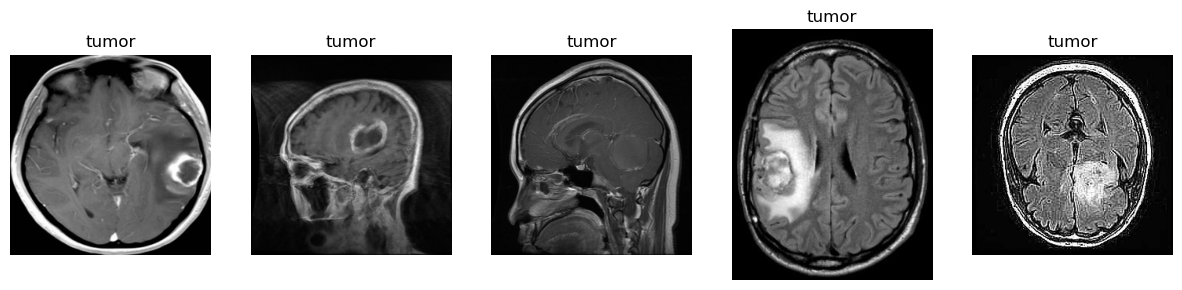

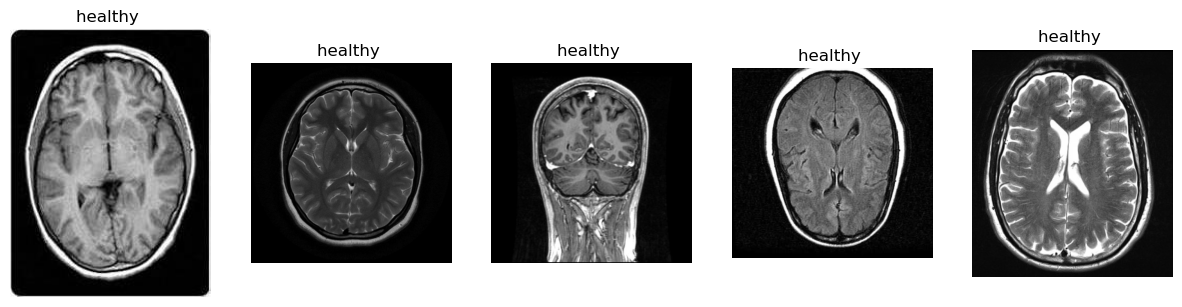

In [7]:
def plot_images(data , image_title, num_of_images):
    plt.figure(figsize=(15,10))
    for i in range(num_of_images):
        random_image = random.choice(data)
        random_image = cv2.imread(random_image)
        
#to convert grayscale img,BGR img to RGB 
#convert the image from BGR to RGB, the colors will appear incorrect       
        
        if len (random_image.shape) == 3:
            random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
        if len (random_image.shape) == 2:
            random_image = cv2.cvtColor(random_image, cv2.COLOR_GRAY2RGB)
            
        plt.subplot(1,num_of_images,i+1)
        plt.imshow(random_image)
        plt.axis('off')
        plt.title(image_title)
    
    plt.show()

plot_images(tumor_train ,'tumor',5)
plot_images(healthy_train ,'healthy ',5)

In [8]:
#The % differance between the 2 classes

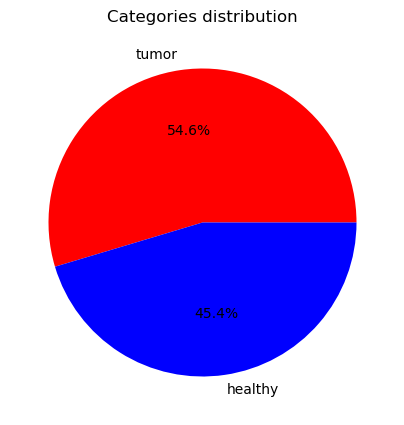

In [9]:
def make_pie(data,labels,colors,title):
    plt.figure(figsize=(16,5))
    plt.pie(data,labels = labels, colors = colors, autopct='%1.1f%%')
    plt.title(title)
    plt.show()
    
data = [len(tumor_train),len(healthy_train)]
labels = ['tumor','healthy']
colors = ['red','blue']
make_pie(data,labels,colors,'Categories distribution')

In [10]:
#Image Augmentation & Preprocessing for Train data

In [11]:


def image_augmentation(data, target, p=0.5):
    
    images = []
    
    # Defining augmentation functions that are (brightness, contrast, rotation, cropping)
    def random_brightness(image, limit=0.5):
        if random.random() < p:
            factor = 1 + random.uniform(-limit, limit)
            return np.clip(image * factor, 0, 255).astype(np.uint8)
        return image
    
    def random_contrast(image, limit=0.5):
        if random.random() < p:
            factor = 1 + random.uniform(-limit, limit)
            mean = np.mean(image, axis=(0, 1), keepdims=True)
            return np.clip((image - mean) * factor + mean, 0, 255).astype(np.uint8)
        return image
    
    def random_rotate(image, limit=40):
        if random.random() < p:
            angle = random.uniform(-limit, limit)
            h, w = image.shape[:2]
            M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
            return cv2.warpAffine(image, M, (w, h))
        return image
    
    def random_crop(image, crop_height=200, crop_width=200):
        if random.random() < p:
            h, w = image.shape[:2]
            if h > crop_height and w > crop_width:
                start_x = random.randint(0, w - crop_width)
                start_y = random.randint(0, h - crop_height)
                return image[start_y:start_y + crop_height, start_x:start_x + crop_width]
        return image
    
    # Augmentation func list
    augmentations_list = [random_brightness, random_contrast, random_rotate, random_crop]

    while len(images) < target:
        for image_path in data:
            # Loading img and resizing to 256x256
            img = cv2.resize(cv2.imread(image_path), (256, 256))
            
            # Converting the image to RGB (if it is grayscale or BGR)
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            
            # Randomly apply an augmentation from the list
            operation = random.choice(augmentations_list)
            img = operation(img)
            
            # Ensuring that  the final img size shpuld be  256x256 after augmentation
            if img.shape[0] != 256 or img.shape[1] != 256:
                img = cv2.resize(img, (256, 256))
            
            images.append(img)
            
            if len(images) >= target:
                break
    
    return np.array(images)


In [12]:
#generating 5k img for both by augmenting training data it will increase the size of dataset which improves performance storing it in 2 variable 

tumor_train_aug = image_augmentation(tumor_train,5000)
healthy_train_aug = image_augmentation(healthy_train,5000)

In [13]:
 #returns no of aug img of train data by adding both healthy and not healthy specifically need both count in %

print ('Train Data = {}'.format(len(tumor_train_aug)+len(healthy_train_aug)))
print ('# of train_tumor_aug = {}'.format(len(tumor_train_aug)))
print ('# of train_healthy_aug = {}'.format(len(healthy_train_aug)))

Train Data = 10000
# of train_tumor_aug = 5000
# of train_healthy_aug = 5000


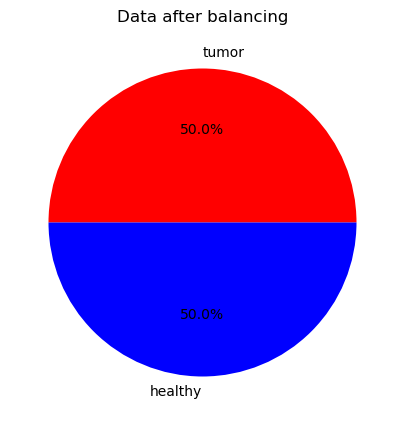

In [14]:
#the above is in visual chart
make_pie([len(tumor_train_aug), len(healthy_train_aug)] ,labels,colors,'Data after balancing')

In [15]:


def plot_images(data, image_title, num_of_images, datagen=None):
    plt.figure(figsize=(12, 12))
    
    for i in range(num_of_images):
        # Choosing a random image from the dataset
        random_image = random.choice(data)

        # Applying augmentation if a data generator is provided
        if datagen:
            augmented_image = datagen.random_transform(random_image)
        else:
            augmented_image = random_image
        
        # Plot the image
        plt.subplot(1, num_of_images, i + 1)
        plt.imshow(np.clip(augmented_image, 0, 1))  # Clipping to [0, 1] range for display
        plt.axis('off')
    
    plt.suptitle(image_title)
    plt.show()


In [16]:





def plot_images(data, image_title, num_of_images, datagen=None):
    plt.figure(figsize=(12, 12))
    
    for i in range(num_of_images):
        # Choosing a random image from the dataset
        random_image = random.choice(data)

        # Applying augmentation if a data generator is provided
        if datagen:
            augmented_image = datagen.random_transform(random_image)
        else:
            augmented_image = random_image
        
        # Ploting the image
        plt.subplot(1, num_of_images, i + 1)
        plt.imshow(np.clip(augmented_image, 0, 1))  # Clipping to [0, 1] range for display
        plt.axis('off')
    
    plt.suptitle(image_title)
    plt.show()


In [17]:


def plot_images(data, image_title, num_of_images, datagen=None):
    plt.figure(figsize=(12, 12))
    
    for i in range(num_of_images):
        # Choose a random image from the dataset
        random_image = random.choice(data)

        # Apply augmentation if a data generator is provided
        if datagen:
            augmented_image = datagen.random_transform(random_image)
        else:
            augmented_image = random_image
        
        # Plot the image
        plt.subplot(1, num_of_images, i + 1)
        plt.imshow(np.clip(augmented_image, 0, 1))  # Clipping to [0, 1] range for display
        plt.axis('off')
    
    plt.suptitle(image_title)
    plt.show()


In [18]:
#preprocessing the test data  by converting to RGB and standordizing it so it will be ready for testing 
#purpose uniform img format and size

def preprocess_test_data(data):
    images = []
    for image in data:
        img = cv2.resize(cv2.imread(image),(256, 256))
        if len (img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if len (img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        images.append(img)
    return np.array(images)

In [19]:
tumor_test = preprocess_test_data(tumor_test)
healthy_test = preprocess_test_data(healthy_test)

In [20]:

import matplotlib.pyplot as plt
import numpy as np
import random

def plot_images(data, image_title, num_of_images, datagen=None):
    plt.figure(figsize=(12, 12))
    
    for i in range(num_of_images):
        # Choosing a random image from the dataset
        random_image = random.choice(data)

        # Applying augmentation if a data generator is provided
        if datagen:
            augmented_image = datagen.random_transform(random_image)
        else:
            augmented_image = random_image
        
        # Ploting the image
        plt.subplot(1, num_of_images, i + 1)
        plt.imshow(np.clip(augmented_image, 0, 1))  # Clipping it to [0, 1] range for displaying
        plt.axis('off')
    
    plt.suptitle(image_title)
    plt.show()


In [21]:
#Concating the both augmented  training and test data

X_train = np.concatenate([tumor_train_aug,healthy_train_aug],axis = 0) #axis 0 makes img staked vertically
X_test = np.concatenate([tumor_test,healthy_test],axis = 0)

# value 0 is used to represent the "tumor" class 
#value 1 is used to represent the "healthy" 

y_train = np.concatenate([np.zeros(len(tumor_train_aug)), np.ones(len(healthy_train_aug))])
y_test = np.concatenate([np.zeros(len(tumor_test)), np.ones(len(healthy_test))])

print (X_train.shape) 
print (y_train.shape) 
print (X_test.shape)
print (y_test.shape)

(10000, 256, 256, 3)
(10000,)
(921, 256, 256, 3)
(921,)


In [22]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=16, shuffle=True)
test_generator = test_datagen.flow(X_test, y_test, batch_size=16, shuffle=True)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense

# Model building
model = Sequential() #which allows to build  neural layer

model.add(InputLayer(input_shape=(256, 256, 3)))

#16 no of filters  to detect 16 diff pattern #3,3 is size of filter # relu to add non linearity  which detects complex pattern 
model.add(Conv2D(16, (3, 3), activation="relu")) 
model.add(MaxPool2D()) #reduces dimension and extract important feature 

#further given 32 to detect more complex feature 
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPool2D())

#which allows model to combine both and high and low level feature
model.add(Conv2D(16, (3, 3), activation="relu"))
model.add(MaxPool2D())

#converts to 2d to 1d 
model.add(Flatten())

#sigmoid  used to binary classification and 256 neurons allows the model to learn complex features 
model.add(Dense(256, activation="relu"))

#This layer has 1 neuron, which makes it suitable for binary classification, as it outputs a single value.
model.add(Dense(1, activation="sigmoid"))




In [24]:
#where we will configure learning process before traing the model and smaller adam  gives more accuracy 
#loss function  cal diff between predicted porbability (o/p from sigmoid activation)and actual label(0-tumor,1-healthy)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1.5e-4),
              loss='binary_crossentropy',
              metrics=['accuracy']) #measures proportion of correct prediction (whether it matches the actual label)

In [25]:
model.save('brain.h5')



In [27]:
#train the model  using train_gen and evaluationg  the performance using validation test_gen.Train_generato yields batches from training img created from
#rescaled trainimg,history contains training history(loss and acc)for both train and test over each epoch

history = model.fit(train_generator,epochs=5,validation_data=test_generator)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 118s 180ms/step - accuracy: 0.7400 - loss: 0.4942 - val_accuracy: 0.9110 - val_loss: 0.2375
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 110s 175ms/step - accuracy: 0.9164 - loss: 0.2127 - val_accuracy: 0.9403 - val_loss: 0.1624
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 173ms/step - accuracy: 0.9556 - loss: 0.1264 - val_accuracy: 0.9435 - val_loss: 0.1509
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 179ms/step - accuracy: 0.9770 - loss: 0.0726 - val_accuracy: 0.9642 - val_loss: 0.1174
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 180ms/step - accuracy: 0.9856 - loss: 0.0416 - val_accuracy: 0.9587 - val_loss: 0.1349


In [28]:
#syas the flow of data & how layers connected
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,089,877 (42.30 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,393,252 (28.20 MB)

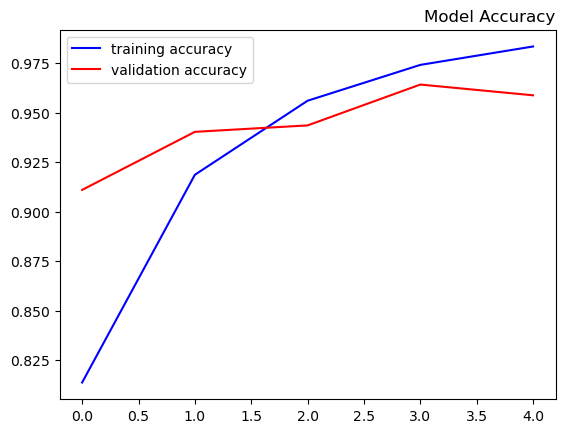

In [29]:
#Plot the Accuracy history

#retrieves training acc and val for each epoch
train_acc = history.history['accuracy'] #how well model fits traindata
val_acc = history.history['val_accuracy']#genralise result to unseen data,both metric further tuning for better outcome

plt.plot(train_acc, c = 'b', label = 'training accuracy')
plt.plot(val_acc, c = 'r', label = 'validation accuracy')
plt.title('Model Accuracy', loc ='right')
plt.legend()
plt.show()

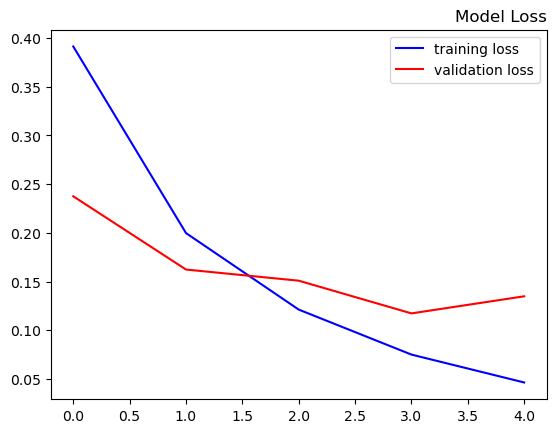

In [30]:
#Plot the loss history

train_loss = history.history['loss'] #how well model fits traindata,less loss indicates model learning from traindata
val_loss = history.history['val_loss']#genralise result to unseen data we can identify whether is overfitting

plt.plot(train_loss, c = 'b', label = 'training loss')
plt.plot(val_loss, c = 'r', label = 'validation loss')
plt.title('Model Loss', loc ='right')
plt.legend() #displays on plot which has train and val lines
plt.show()

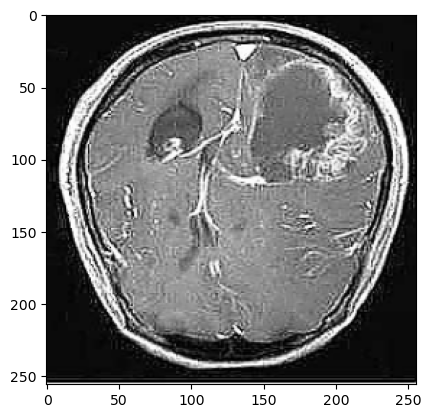

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
The predicted class is Tumor Brain


In [35]:


# Provide a specific image file, not a directory
img_path = r"C:\Users\aishu\Downloads\brain tumour\Brain Tumor Data Set\Brain Tumor Data Set\Brain Tumor\Cancer (1354).jpg"

# Read the image
img = cv2.imread(img_path)

# Check if image is loaded correctly
if img is None:
    print("Error: Image not loaded. Check the file path.")
else:
    # Resize the image to 256x256
    resized = tf.image.resize(img, (256, 256))
    
    # Display the resized image
    plt.imshow(resized.numpy().astype(int))
    plt.show()

    # Normalize and predict
    yhat = model.predict(np.expand_dims(resized / 255, 0))
    
    # Classify based on the model's output
    if yhat > 0.5:
        print("The predicted class is Healthy Brain")
    else:
        print("The predicted class is Tumor Brain")
